# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.functional as F

import os
import tqdm
import seaborn as sns
import matplotlib.pylab as plt

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/MyDrive/Train_rev1.zip
data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

Mounted at /content/drive
Archive:  drive/MyDrive/Train_rev1.zip
  inflating: Train_rev1.csv          


(244768, 12)

In [ ]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

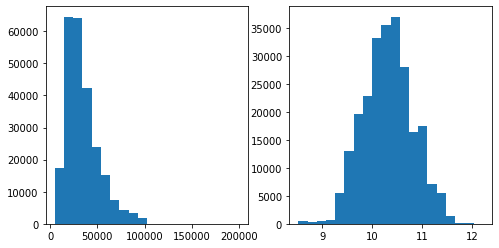

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
218038,72300650,Technical Field Sales Engineer Lubricants,An experienced and ambitious Technical Field S...,UK Wide,UK,full_time,permanent,Motorecruit.co.uk,Engineering Jobs,25000,25000,strike-jobs.co.uk,10.126671
116489,69788025,Senior PHP Developer,Job Title: Senior PHP Developer Salary: **** ...,Cambridgeshire Peterborough PE1 1,Pode Hole,NaN,permanent,Cooper Lomaz Recruitment Limited,IT Jobs,38000.00 - 45000.00 GBP Annual,41500,jobserve.com,10.633472
195226,71798366,Year **** Class Teacher,Are you an experienced Year **** class teacher...,London,London,full_time,contract,Edustaff,Teaching Jobs,From 135 to 155 per day + Potentially Permanent,34800,jobsineducation.co.uk,10.457401


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [ ]:
  print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


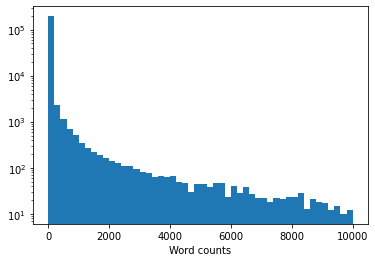

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=77)
data_test, data_val = train_test_split(data_test, test_size=0.5, random_state=77)

data_train.index = range(len(data_train))
data_test.index = range(len(data_test))
data_val.index = range(len(data_val))


print("Train size =", len(data_train))
print("Test  size =", len(data_test))
print("Val   size =", len(data_val))

Train size = 195814
Test  size = 24477
Val   size = 24477


In [ ]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
make_batch(data_train[:3], max_len=10)

{'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'FullDescription': tensor([[16100, 25392,  2572, 23464, 31100,  3642, 25390, 21788,  3737, 21634],
         [24265, 18864, 26009, 12587, 30847, 14618, 15910,   158,  7864,  2189],
         [30602, 29369,  3064,  2844,  3547, 15554,  7901, 22746,    82, 31100]]),
 'Log1pSalary': tensor([ 9.6804, 11.1563,  9.5105]),
 'Title': tensor([[22397,     1,     1],
         [24265, 18864,     1],
         [29369,  3064,  2844]])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictor()

In [ ]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: 
          break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [ ]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cuda')

In [ ]:
def print_val(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            squared_error += torch.mean(torch.square(model(batch) - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(model(batch) - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [ ]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train)
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)

NameError: ignored

CHECKPOINTS

In [ ]:
def save_checkpoint(model, optimizer, iteration, path):
  torch.save({'iteration': iteration, 'state_dict':  model.state_dict(),
              'optimizer': optimizer.state_dict(), 'learning_rate': optimizer.state_dict()['param_groups'][0]['lr']}, path)
  
def load_checkpoint(checkpoint_path, model, optimizer):
  model.load_state_dict(torch.load(checkpoint_path, map_location='cpu')['state_dict'])
  optimizer.load_state_dict(torch.load(checkpoint_path, map_location='cpu')['optimizer'])
  learning_rate = torch.load(checkpoint_path, map_location='cpu')['learning_rate']
  iteration = torch.load(checkpoint_path, map_location='cpu')['iteration']
  return model, optimizer, learning_rate, iteration

Utils

In [ ]:
def draw_metrics(train_loss_list, metrics_dict):
  p1 = sns.lineplot(data=metrics_dict['MSE'])
  p2 = sns.lineplot(data=metrics_dict['MAE'])
  p3 = sns.lineplot(data=train_loss_list)
  p1.set_xlabel("Step", fontsize = 10)
  p1.set_ylabel("Loss", fontsize = 10)
  plt.title("MSE")
  plt.show()
  p2.set_xlabel("Step", fontsize = 10)
  p2.set_ylabel("Loss", fontsize = 10)
  plt.title("MAE")
  plt.show()
  p3.set_xlabel("Step", fontsize = 10)
  p3.set_ylabel("Loss", fontsize = 10)
  plt.title("Train Loss")
  plt.show()

def print_metrics(train_loss_list, metrics_dict, iterations_list, subview_start_index=4, mode='lines', dash='dash'):
  trend_fig = make_subplots(rows=1, cols=2)
  mse_train = metrics_dict['MSE']['train']
  mse_val = metrics_dict['MSE']['val']
  mae_train = metrics_dict['MAE']['train']
  mae_val = metrics_dict['MAE']['val']
  trend_fig.add_trace(go.Scatter(y=mse_train, x=iterations_list, mode=mode, line=dict(color='red'), name='MSE Train'), row=1, col=1)
  trend_fig.add_trace(go.Scatter(y=mse_val, x=iterations_list, mode=mode, line=dict(color='red', dash=dash), name='MSE Validation'), row=1, col=1)
  trend_fig.add_trace(go.Scatter(y=mae_train, x=iterations_list, mode=mode, line=dict(color='blue'), name='MAE Train'), row=1, col=1)
  trend_fig.add_trace(go.Scatter(y=mae_val, x=iterations_list, mode=mode, line=dict(color='blue', dash=dash), name='MAE Validation'), row=1, col=1)
  trend_fig.add_trace(go.Scatter(y=mse_train[subview_start_index:], x=iterations_list[subview_start_index:], mode=mode, line=dict(color='red'), name='MSE Train'), row=1, col=2)
  trend_fig.add_trace(go.Scatter(y=mse_val[subview_start_index:], x=iterations_list[subview_start_index:], mode=mode, line=dict(color='red', dash=dash), name='MSE Validation'), row=1, col=2)
  trend_fig.add_trace(go.Scatter(y=mae_train[subview_start_index:], x=iterations_list[subview_start_index:], mode=mode, line=dict(color='blue'), name='MAE Train'), row=1, col=2)
  trend_fig.add_trace(go.Scatter(y=mae_val[subview_start_index:], x=iterations_list[subview_start_index:], mode=mode, line=dict(color='blue', dash=dash), name='MAE Validation'), row=1, col=2)
  trend_fig.layout.title = "Model metrics"
  trend_fig.show()
  trend_fig2 = go.Figure()
  trend_fig2.layout.title = "Train Loss"
  trend_fig2.add_trace(go.Scatter(y=train_loss_list, x=iterations_list, mode=mode, name='Train Loss'))
  trend_fig2.show()

def train(mae, mse, pred, column):
  with torch.no_grad():
    trn_mse, trn_mae = mse(pred, column).cpu(), mae(pred, column).cpu()
    trn_mse, trn_mae = float(trn_mse.detach().numpy()), float(trn_mae.detach().numpy())
    return trn_mse, trn_mae 

def early_stop(stop, ep_impr, threshold, no_impr):
  flag = 1
  if not ep_impr:
    no_impr +=1
  if stop and no_impr >= threshold:
    flag = 0
  return no_impr, flag

def traininig_model(model, optimizer, criterion, data_train, data_val, batch_size=128, epochs=10, val_iter=100,
          checkpoint_path="./checkpoint.pt", device=None, early_stopping=False, early_stopping_threshold=2):
  mae, mse = nn.L1Loss(), nn.MSELoss()
  train_loss_list, train_mse_list, train_mae_list, validation_mse_list, validation_mae_list = [], [], [], [], []
  best_metric = None
  val_iterations_list = list()
  iter = 0
  no_impr = 0
  for epoch in range(epochs):
      print(f"epoch: {epoch}")
      epoch_improve = False
      for it, batch in tqdm.notebook.tqdm(
          enumerate(iterate_minibatches(data_train, batch_size=batch_size, device=device)), 
                  total=len(data_train)):
          iter += 1
          model.train()
          pred = model(batch)
          optimizer.zero_grad()
          loss = criterion(pred, batch[TARGET_COLUMN])
          loss.backward()
          optimizer.step()
          if it % val_iter == 0 and it:
              print(f"Train Iteration: {it}")
              print('train_loss', loss.item())
              train_loss_list.append(loss.item())
              trn_mse, trn_mae = train(mae, mse, pred, batch[TARGET_COLUMN])
              train_mse_list.append(trn_mse)
              train_mae_list.append(trn_mae)
              val_mse, val_mae = validatation_actions(model, data_val, name='val', batch_size=batch_size, device=device)
              validation_mse_list.append(val_mse)
              validation_mae_list.append(val_mae)
              val_iterations_list.append(iter)
              if best_metric is None or best_metric > val_mse:
                best_metric = val_mse
                save_checkpoint(model, optimizer, it, checkpoint_path)
                epoch_improve = True
                no_improve = 0
      no_improve, flag = early_stop(early_stopping, epoch_improve, early_stopping_threshold, no_improve)
      if not flag:
        print(f"Early stop: {no_improve} epochs without improvement in metric")
        break
  metrics = {
      "MSE": {
          "train": train_mse_list,
          "val": validation_mse_list,
      },
      "MAE": {
          "train": train_mae_list,
          "val": validation_mae_list,
      }
  }
  return train_loss_list, metrics, val_iterations_list

**1. Развейте СNN архитектуру (2 балла)**

Добавьте в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавьте раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано. 

Как модель ведет себя в зависимости от количества обучаемых параметров?


Добавим Batch Normaliztion

In [ ]:
class SalaryPredictorWithBatchNorm(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_batch_norm = SalaryPredictorWithBatchNorm().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_batch_norm.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(model_batch_norm, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='the_best_bn.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 75.09031677246094
val results:
MSE: 18.1855240
MAE: 2.1276983
Train Iteration: 400
train_loss 42.70018005371094
val results:
MSE: 10.8336207
MAE: 1.6139528
Train Iteration: 600
train_loss 21.454206466674805
val results:
MSE: 5.5506878
MAE: 1.0759194
Train Iteration: 800
train_loss 10.313580513000488
val results:
MSE: 2.7301343
MAE: 0.6496211
Train Iteration: 1000
train_loss 3.312044858932495
val results:
MSE: 1.1876771
MAE: 0.3811125
Train Iteration: 1200
train_loss 1.5399582386016846
val results:
MSE: 0.3757490
MAE: 0.2207921
Train Iteration: 1400
train_loss 0.6875354051589966
val results:
MSE: 0.0889416
MAE: 0.1154444
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.36413127183914185
val results:
MSE: 0.0460040
MAE: 0.0820304
Train Iteration: 400
train_loss 0.1256256103515625
val results:
MSE: 0.0430440
MAE: 0.0802252
Train Iteration: 600
train_loss 0.5327838063240051
val results:
MSE: 0.0836129
MAE: 0.1177049
Train Iteration: 800
train_loss 0.5870117545127869
val results:
MSE: 0.0430641
MAE: 0.0795547
Train Iteration: 1000
train_loss 0.246131032705307
val results:
MSE: 0.0661496
MAE: 0.1023322
Train Iteration: 1200
train_loss 0.27921441197395325
val results:
MSE: 0.1124039
MAE: 0.1301288
Train Iteration: 1400
train_loss 0.19309288263320923
val results:
MSE: 0.0337449
MAE: 0.0702629
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.12717574834823608
val results:
MSE: 0.0359992
MAE: 0.0727857
Train Iteration: 400
train_loss 0.11128545552492142
val results:
MSE: 0.0321478
MAE: 0.0686105
Train Iteration: 600
train_loss 0.1274346560239792
val results:
MSE: 0.0394518
MAE: 0.0776559
Train Iteration: 800
train_loss 0.12118087708950043
val results:
MSE: 0.0364901
MAE: 0.0740534
Train Iteration: 1000
train_loss 0.11938849836587906
val results:
MSE: 0.0313784
MAE: 0.0678873
Train Iteration: 1200
train_loss 0.1308528482913971
val results:
MSE: 0.0362858
MAE: 0.0744334
Train Iteration: 1400
train_loss 0.1266612559556961
val results:
MSE: 0.0317825
MAE: 0.0682292


In [ ]:
print_metrics(train_loss_list[1:], metrics, [i for i in range(len(train_loss_list))])

In [ ]:
load_checkpoint('the_best_bn.pt', model_batch_norm, optimizer)
print_val(model_batch_norm, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0316565
MAE: 0.0678644


**Добавим Layer Normalization**

In [ ]:
class SalaryPredictorWithLayerNorm(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.LayerNorm(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_layer_norm = SalaryPredictorWithLayerNorm().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_layer_norm.parameters(), lr=1e-3)
train_loss_list, metrics, iters = training_model(model_layer_norm, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='the_best_layer_norm.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 56.716346740722656
val results:
MSE: 14.2186305
MAE: 1.8813572
Train Iteration: 400
train_loss 27.740066528320312
val results:
MSE: 7.0227636
MAE: 1.3192953
Train Iteration: 600
train_loss 10.23183536529541
val results:
MSE: 2.4802663
MAE: 0.7777646
Train Iteration: 800
train_loss 2.018979072570801
val results:
MSE: 0.5852689
MAE: 0.3624995
Train Iteration: 1000
train_loss 0.5663819909095764
val results:
MSE: 0.1277682
MAE: 0.1471977
Train Iteration: 1200
train_loss 0.2715483605861664
val results:
MSE: 0.0656051
MAE: 0.1027663
Train Iteration: 1400
train_loss 0.32085591554641724
val results:
MSE: 0.0608629
MAE: 0.0991126
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.16832593083381653
val results:
MSE: 0.0492056
MAE: 0.0870883
Train Iteration: 400
train_loss 0.15650752186775208
val results:
MSE: 0.0441882
MAE: 0.0822992
Train Iteration: 600
train_loss 0.13618497550487518
val results:
MSE: 0.0408945
MAE: 0.0786519
Train Iteration: 800
train_loss 0.14246469736099243
val results:
MSE: 0.0408211
MAE: 0.0788109
Train Iteration: 1000
train_loss 0.14836379885673523
val results:
MSE: 0.0389927
MAE: 0.0767677
Train Iteration: 1200
train_loss 0.13499298691749573
val results:
MSE: 0.0396893
MAE: 0.0778726
Train Iteration: 1400
train_loss 0.1430537849664688
val results:
MSE: 0.0392515
MAE: 0.0775503
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.14336034655570984
val results:
MSE: 0.0402671
MAE: 0.0789421
Train Iteration: 400
train_loss 0.12031199038028717
val results:
MSE: 0.0350558
MAE: 0.0729187
Train Iteration: 600
train_loss 0.08687463402748108
val results:
MSE: 0.0339064
MAE: 0.0715292
Train Iteration: 800
train_loss 0.15468443930149078
val results:
MSE: 0.0340114
MAE: 0.0716816
Train Iteration: 1000
train_loss 0.08694722503423691
val results:
MSE: 0.0298175
MAE: 0.0663659
Train Iteration: 1200
train_loss 0.09563834965229034
val results:
MSE: 0.0350943
MAE: 0.0736121
Train Iteration: 1400
train_loss 0.06736143678426743
val results:
MSE: 0.0302976
MAE: 0.0669381


In [ ]:
print_metrics(train_loss_list, metrics, [i for i in range(len(train_loss_list))], 4)

In [ ]:
load_checkpoint('the_best_layer_norm.pt', model_layer_norm, optimizer)
print_val(model_layer_norm, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0301989
MAE: 0.0667319


**Параллельные сверточные слои**

In [ ]:
class SalaryPredictorWithParallConv(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.title_encoder2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * (4 + 2), hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features2 = self.title_encoder2(title_embeddings).squeeze()
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features2 = self.description_encoder2(description_embeddings).squeeze()
        title_features = torch.concat((title_features1, title_features2), dim=1)
        description_features = torch.cat((description_features1, description_features2), dim=1)
        categorical_features = self.categorical_encoder(batch['Categorical'])
        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_parall = SalaryPredictorWithParallConv().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_parall.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(model_parall, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='CNN_PARALL.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 59.95337677001953
val results:
MSE: 14.7811826
MAE: 1.9183710
Train Iteration: 400
train_loss 29.576446533203125
val results:
MSE: 7.2042516
MAE: 1.3363795
Train Iteration: 600
train_loss 9.204387664794922
val results:
MSE: 2.2262832
MAE: 0.7358107
Train Iteration: 800
train_loss 1.6086697578430176
val results:
MSE: 0.4134239
MAE: 0.2978340
Train Iteration: 1000
train_loss 0.4162982106208801
val results:
MSE: 0.0903571
MAE: 0.1213474
Train Iteration: 1200
train_loss 0.2813701331615448
val results:
MSE: 0.0620007
MAE: 0.0999516
Train Iteration: 1400
train_loss 0.1942182034254074
val results:
MSE: 0.0605705
MAE: 0.0988262
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.23057988286018372
val results:
MSE: 0.0474862
MAE: 0.0862655
Train Iteration: 400
train_loss 0.1851816475391388
val results:
MSE: 0.0421696
MAE: 0.0810464
Train Iteration: 600
train_loss 0.11320527642965317
val results:
MSE: 0.0387700
MAE: 0.0771208
Train Iteration: 800
train_loss 0.1443158984184265
val results:
MSE: 0.0373572
MAE: 0.0759035
Train Iteration: 1000
train_loss 0.145838662981987
val results:
MSE: 0.0366047
MAE: 0.0750630
Train Iteration: 1200
train_loss 0.09857150912284851
val results:
MSE: 0.0347249
MAE: 0.0727958
Train Iteration: 1400
train_loss 0.12001819163560867
val results:
MSE: 0.0333475
MAE: 0.0710166
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.1354520618915558
val results:
MSE: 0.0312802
MAE: 0.0683952
Train Iteration: 400
train_loss 0.10340908169746399
val results:
MSE: 0.0304788
MAE: 0.0674303
Train Iteration: 600
train_loss 0.0867161974310875
val results:
MSE: 0.0288962
MAE: 0.0653621
Train Iteration: 800
train_loss 0.13834209740161896
val results:
MSE: 0.0272971
MAE: 0.0632154
Train Iteration: 1000
train_loss 0.11348466575145721
val results:
MSE: 0.0273540
MAE: 0.0634089
Train Iteration: 1200
train_loss 0.06232582405209541
val results:
MSE: 0.0253030
MAE: 0.0605263
Train Iteration: 1400
train_loss 0.12053266167640686
val results:
MSE: 0.0252828
MAE: 0.0605173


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('CNN_PARALL.pt', model_parall, optimizer)
validatation_actions(model_parall, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0258939
MAE: 0.0610470


**Дополнительные слои с остановкой**

In [ ]:
class SalaryPredictorWithMoreConvLayers(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.title_encoder2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.LayerNorm(hid_size * 4),
            nn.ReLU(),
            # 
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * (4 + 2), hid_size * 2),
            nn.GroupNorm(1, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )   
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features2 = self.title_encoder2(title_embeddings).squeeze()
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features2 = self.description_encoder2(description_embeddings).squeeze()
        title_features = torch.concat((title_features1, title_features2), dim=1)
        description_features = torch.cat((description_features1, description_features2), dim=1)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_more_layers = SalaryPredictorWithMoreConvLayers(hid_size=16).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_more_layers.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(model_more_layers, optimizer, criterion, data_train, data_val, BATCH_SIZE, 7,
                                        device=DEVICE, val_iter=200, checkpoint_path='CNN_MORE_LAYERS.pt', early_stopping=True)

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 47.67653274536133
val results:
MSE: 11.6734594
MAE: 1.7038822
Train Iteration: 400
train_loss 13.466172218322754
val results:
MSE: 3.3722099
MAE: 0.9098914
Train Iteration: 600
train_loss 1.8700530529022217
val results:
MSE: 0.4248332
MAE: 0.3025525
Train Iteration: 800
train_loss 0.33522212505340576
val results:
MSE: 0.0748177
MAE: 0.1097896
Train Iteration: 1000
train_loss 0.21589039266109467
val results:
MSE: 0.0607758
MAE: 0.0990370
Train Iteration: 1200
train_loss 0.1896931231021881
val results:
MSE: 0.0605554
MAE: 0.0988186
Train Iteration: 1400
train_loss 0.24977126717567444
val results:
MSE: 0.0584343
MAE: 0.0969031
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.16835875809192657
val results:
MSE: 0.0384358
MAE: 0.0761661
Train Iteration: 400
train_loss 0.15991154313087463
val results:
MSE: 0.0322015
MAE: 0.0690557
Train Iteration: 600
train_loss 0.10860902070999146
val results:
MSE: 0.0293916
MAE: 0.0654282
Train Iteration: 800
train_loss 0.12500381469726562
val results:
MSE: 0.0277430
MAE: 0.0632354
Train Iteration: 1000
train_loss 0.10117711126804352
val results:
MSE: 0.0274735
MAE: 0.0631763
Train Iteration: 1200
train_loss 0.12006129324436188
val results:
MSE: 0.0259151
MAE: 0.0610073
Train Iteration: 1400
train_loss 0.08959224075078964
val results:
MSE: 0.0231770
MAE: 0.0570693
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.057600270956754684
val results:
MSE: 0.0230505
MAE: 0.0568622
Train Iteration: 400
train_loss 0.1066758781671524
val results:
MSE: 0.0220656
MAE: 0.0553536
Train Iteration: 600
train_loss 0.07357220351696014
val results:
MSE: 0.0216254
MAE: 0.0549837
Train Iteration: 800
train_loss 0.06654345989227295
val results:
MSE: 0.0231657
MAE: 0.0573330
Train Iteration: 1000
train_loss 0.08037224411964417
val results:
MSE: 0.0207321
MAE: 0.0536083
Train Iteration: 1200
train_loss 0.0886332094669342
val results:
MSE: 0.0197111
MAE: 0.0521762
Train Iteration: 1400
train_loss 0.0782768726348877
val results:
MSE: 0.0216299
MAE: 0.0552640
epoch: 3


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.0879746824502945
val results:
MSE: 0.0213829
MAE: 0.0549559
Train Iteration: 400
train_loss 0.06440409272909164
val results:
MSE: 0.0198597
MAE: 0.0525307
Train Iteration: 600
train_loss 0.07920235395431519
val results:
MSE: 0.0189202
MAE: 0.0509128
Train Iteration: 800
train_loss 0.0774211660027504
val results:
MSE: 0.0180952
MAE: 0.0495466
Train Iteration: 1000
train_loss 0.0918104499578476
val results:
MSE: 0.0204642
MAE: 0.0537337
Train Iteration: 1200
train_loss 0.06624963879585266
val results:
MSE: 0.0183307
MAE: 0.0500522
Train Iteration: 1400
train_loss 0.08768418431282043
val results:
MSE: 0.0181907
MAE: 0.0497600
epoch: 4


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.05922207236289978
val results:
MSE: 0.0184127
MAE: 0.0502054
Train Iteration: 400
train_loss 0.050755035132169724
val results:
MSE: 0.0176899
MAE: 0.0489442
Train Iteration: 600
train_loss 0.04847625643014908
val results:
MSE: 0.0173278
MAE: 0.0484360
Train Iteration: 800
train_loss 0.05525975674390793
val results:
MSE: 0.0173661
MAE: 0.0485877
Train Iteration: 1000
train_loss 0.04031859338283539
val results:
MSE: 0.0189914
MAE: 0.0511430
Train Iteration: 1200
train_loss 0.08708930015563965
val results:
MSE: 0.0178222
MAE: 0.0493808
Train Iteration: 1400
train_loss 0.06685040891170502
val results:
MSE: 0.0193446
MAE: 0.0520636
epoch: 5


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.08867743611335754
val results:
MSE: 0.0174173
MAE: 0.0485676
Train Iteration: 400
train_loss 0.055202968418598175
val results:
MSE: 0.0170263
MAE: 0.0475977
Train Iteration: 600
train_loss 0.04965941607952118
val results:
MSE: 0.0184360
MAE: 0.0503039
Train Iteration: 800
train_loss 0.059817783534526825
val results:
MSE: 0.0168589
MAE: 0.0474386
Train Iteration: 1000
train_loss 0.05729511380195618
val results:
MSE: 0.0183365
MAE: 0.0501598
Train Iteration: 1200
train_loss 0.04518618434667587
val results:
MSE: 0.0167433
MAE: 0.0473197
Train Iteration: 1400
train_loss 0.04255077242851257
val results:
MSE: 0.0168150
MAE: 0.0475459
epoch: 6


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.041961584240198135
val results:
MSE: 0.0176422
MAE: 0.0489506
Train Iteration: 400
train_loss 0.051512669771909714
val results:
MSE: 0.0165609
MAE: 0.0469764
Train Iteration: 600
train_loss 0.03869476541876793
val results:
MSE: 0.0173584
MAE: 0.0484486
Train Iteration: 800
train_loss 0.04920673742890358
val results:
MSE: 0.0163529
MAE: 0.0467121
Train Iteration: 1000
train_loss 0.07279855012893677
val results:
MSE: 0.0169603
MAE: 0.0475192
Train Iteration: 1200
train_loss 0.04103567451238632
val results:
MSE: 0.0159980
MAE: 0.0461356
Train Iteration: 1400
train_loss 0.04394989088177681
val results:
MSE: 0.0163634
MAE: 0.0467932


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('CNN_MORE_LAYERS.pt', model_more_layers, optimizer)
print_val(model_more_layers, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0160969
MAE: 0.0459878


**Conclusion**

### 1) Из опытов можно сделать вывод, что модели плюс минус имеют одинаковое поведение, каких-то отличительных случаев нет
### 2) Модель с дополнительным количеством линейных слоев показала наилучшие метрики, что и было ожидаемо
### 3) При это Batch Nornalization и Layer Norm имеют наиболее близкие результаты

**2. Pooling слои стандартные (1 балла)**

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

# Pooling дает нам возможность отмечать значительные признаки и брать их определенную совокупность. Что в итоге уменьшает размерность выходного слоя, так как происходит своего рода обобщение получаемых данных

In [ ]:
class SeqMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
      return x.amax(dim=self.dim)

class SalaryPredictorPoolMax(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            SeqMaxPooling(dim=-1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            SeqMaxPooling(dim=-1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.LayerNorm(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_pool_max = SalaryPredictorPoolMax().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pool_max.parameters(), lr=1e-3)
train_loss_list, metrics, iters = training_model(model_pool_max, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='CNN_MAX_POOLING.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 73.60977172851562
val results:
MSE: 18.1679827
MAE: 2.1276375
Train Iteration: 400
train_loss 41.97069549560547
val results:
MSE: 10.5007006
MAE: 1.6155569
Train Iteration: 600
train_loss 17.53712272644043
val results:
MSE: 4.3764416
MAE: 1.0387301
Train Iteration: 800
train_loss 4.948453903198242
val results:
MSE: 1.2204855
MAE: 0.5384901
Train Iteration: 1000
train_loss 1.0136710405349731
val results:
MSE: 0.2494300
MAE: 0.2199830
Train Iteration: 1200
train_loss 0.2870829105377197
val results:
MSE: 0.0788416
MAE: 0.1128197
Train Iteration: 1400
train_loss 0.20053310692310333
val results:
MSE: 0.0616732
MAE: 0.0997159
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.2619437575340271
val results:
MSE: 0.0494963
MAE: 0.0878666
Train Iteration: 400
train_loss 0.18339386582374573
val results:
MSE: 0.0433256
MAE: 0.0811868
Train Iteration: 600
train_loss 0.15539336204528809
val results:
MSE: 0.0396331
MAE: 0.0776610
Train Iteration: 800
train_loss 0.11336271464824677
val results:
MSE: 0.0388985
MAE: 0.0767440
Train Iteration: 1000
train_loss 0.1127755343914032
val results:
MSE: 0.0366476
MAE: 0.0743125
Train Iteration: 1200
train_loss 0.1531275510787964
val results:
MSE: 0.0339840
MAE: 0.0710483
Train Iteration: 1400
train_loss 0.13161787390708923
val results:
MSE: 0.0313475
MAE: 0.0677420
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.0723513811826706
val results:
MSE: 0.0299547
MAE: 0.0659732
Train Iteration: 400
train_loss 0.1615511178970337
val results:
MSE: 0.0286611
MAE: 0.0644684
Train Iteration: 600
train_loss 0.0889846682548523
val results:
MSE: 0.0279020
MAE: 0.0634603
Train Iteration: 800
train_loss 0.08721576631069183
val results:
MSE: 0.0273387
MAE: 0.0626524
Train Iteration: 1000
train_loss 0.07003666460514069
val results:
MSE: 0.0261872
MAE: 0.0611419
Train Iteration: 1200
train_loss 0.09427007287740707
val results:
MSE: 0.0243215
MAE: 0.0584391
Train Iteration: 1400
train_loss 0.11879383027553558
val results:
MSE: 0.0244185
MAE: 0.0585731


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('CNN_MAX_POOLING.pt', model_pool_max, optimizer)
print_val(model_pool_max, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0245481
MAE: 0.0586975


Средний пулинг

In [ ]:
class SalaryPredictorPooling(nn.Module):
    def __init__(self, PoolLayer, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
        )
        self.pooling_1 = PoolLayer(output_size=hid_size)
        self.pooling_2 = PoolLayer(output_size=hid_size)
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )        
    def forward(self, batch): 
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings)
        title_features = self.pooling_1(title_features)       
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings)
        description_features = self.pooling_2(description_features)       
        categorical_features = self.categorical_encoder(batch['Categorical'])
        title_features = torch.flatten(title_features, start_dim=1)      
        description_features = torch.flatten(description_features, start_dim=1)      
        features = torch.cat([title_features, description_features, categorical_features], dim=1)     
        return self.final_predictor(features).squeeze()

In [ ]:
avg_pooling = nn.AdaptiveAvgPool1d
average_model = SalaryPredictorPooling(avg_pooling).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(average_model.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(average_model, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='CNN_AVERAGE_POOLING.pt')

epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.5888581275939941
val results:
MSE: 0.1351544
MAE: 0.1436986
Train Iteration: 400
train_loss 0.5288870334625244
val results:
MSE: 0.0579235
MAE: 0.0949715
Train Iteration: 600
train_loss 0.18830056488513947
val results:
MSE: 0.0473862
MAE: 0.0852391
Train Iteration: 800
train_loss 0.2577853798866272
val results:
MSE: 0.0424561
MAE: 0.0801842
Train Iteration: 1000
train_loss 0.24787446856498718
val results:
MSE: 0.0393097
MAE: 0.0771226
Train Iteration: 1200
train_loss 0.19209027290344238
val results:
MSE: 0.0373212
MAE: 0.0748155
Train Iteration: 1400
train_loss 0.20020586252212524
val results:
MSE: 0.0358963
MAE: 0.0735787
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.17087551951408386
val results:
MSE: 0.0335161
MAE: 0.0706652
Train Iteration: 400
train_loss 0.1835782825946808
val results:
MSE: 0.0326254
MAE: 0.0697603
Train Iteration: 600
train_loss 0.15148097276687622
val results:
MSE: 0.0322417
MAE: 0.0695270
Train Iteration: 800
train_loss 0.14334169030189514
val results:
MSE: 0.0310715
MAE: 0.0676580
Train Iteration: 1000
train_loss 0.12717902660369873
val results:
MSE: 0.0301788
MAE: 0.0666938
Train Iteration: 1200
train_loss 0.1277414709329605
val results:
MSE: 0.0295352
MAE: 0.0659388
Train Iteration: 1400
train_loss 0.14590874314308167
val results:
MSE: 0.0287379
MAE: 0.0647925
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.13049215078353882
val results:
MSE: 0.0277139
MAE: 0.0634956
Train Iteration: 400
train_loss 0.14768585562705994
val results:
MSE: 0.0278593
MAE: 0.0633883
Train Iteration: 600
train_loss 0.09234407544136047
val results:
MSE: 0.0265473
MAE: 0.0618982
Train Iteration: 800
train_loss 0.08464705944061279
val results:
MSE: 0.0259866
MAE: 0.0611055
Train Iteration: 1000
train_loss 0.13458916544914246
val results:
MSE: 0.0254685
MAE: 0.0604171
Train Iteration: 1200
train_loss 0.11702577024698257
val results:
MSE: 0.0250879
MAE: 0.0597474
Train Iteration: 1400
train_loss 0.09303750097751617
val results:
MSE: 0.0245023
MAE: 0.0591994


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('CNN_AVERAGE_POOLING.pt', average_model, optimizer)
_, _ = validatation_actions(average_model, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0247921
MAE: 0.0595052


## Не убирал PAD символы, но по результатам могу сказать, что оба случая временной компоненты дают примерно одинаковые метрики

**3. Используйте предобученные эмбеддинги (2 балла)**

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попбровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

In [ ]:
import gensim.downloader as loader

def load_weights(title):
    weights = loader.load(title)
    weights = torch.FloatTensor(weights.vectors)
    return weights

In [ ]:
title = "glove-wiki-gigaword-50"
weights = load_weights(title)
size = int(title.split("-")[-1])

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
class SalaryPredictorEMBEDDING(nn.Module):
    def __init__(self, weights, freeze, size, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights)
        self.embedder.requires_grad_ = freeze
        self.title_encoder = nn.Sequential(
            nn.Conv1d(size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
        
        categorical_features = self.categorical_encoder(batch['Categorical'])
        features = torch.cat([title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
freeze_model = SalaryPredictorEMBEDDING(weights=weights, freeze=True, size=size).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(freeze_model.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(freeze_model, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='CNN_embed_freeze.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.5863062143325806
val results:
MSE: 1.2430159
MAE: 0.5320030
Train Iteration: 400
train_loss 0.6229612231254578
val results:
MSE: 1.1492554
MAE: 0.5169904
Train Iteration: 600
train_loss 0.32386666536331177
val results:
MSE: 1.0832198
MAE: 0.5049100
Train Iteration: 800
train_loss 0.31566616892814636
val results:
MSE: 1.0050189
MAE: 0.4875876
Train Iteration: 1000
train_loss 0.25177568197250366
val results:
MSE: 1.0018796
MAE: 0.4881886
Train Iteration: 1200
train_loss 0.20483559370040894
val results:
MSE: 0.9057899
MAE: 0.4639309
Train Iteration: 1400
train_loss 0.18360507488250732
val results:
MSE: 0.8704901
MAE: 0.4549849
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.17097489535808563
val results:
MSE: 0.8381397
MAE: 0.4466476
Train Iteration: 400
train_loss 0.15470752120018005
val results:
MSE: 0.7566016
MAE: 0.4235894
Train Iteration: 600
train_loss 0.17213737964630127
val results:
MSE: 0.7414762
MAE: 0.4193880
Train Iteration: 800
train_loss 0.14798694849014282
val results:
MSE: 0.7428797
MAE: 0.4199904
Train Iteration: 1000
train_loss 0.18060973286628723
val results:
MSE: 0.7241360
MAE: 0.4146086
Train Iteration: 1200
train_loss 0.1583462655544281
val results:
MSE: 0.6904374
MAE: 0.4044851
Train Iteration: 1400
train_loss 0.14670780301094055
val results:
MSE: 0.6488871
MAE: 0.3915957
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.12921270728111267
val results:
MSE: 0.6406418
MAE: 0.3892308
Train Iteration: 400
train_loss 0.15722358226776123
val results:
MSE: 0.6281279
MAE: 0.3853909
Train Iteration: 600
train_loss 0.13862474262714386
val results:
MSE: 0.6218647
MAE: 0.3835392
Train Iteration: 800
train_loss 0.13024422526359558
val results:
MSE: 0.5955034
MAE: 0.3749730
Train Iteration: 1000
train_loss 0.1258057802915573
val results:
MSE: 0.5708257
MAE: 0.3668598
Train Iteration: 1200
train_loss 0.11923746019601822
val results:
MSE: 0.5796548
MAE: 0.3700089
Train Iteration: 1400
train_loss 0.12696030735969543
val results:
MSE: 0.5689044
MAE: 0.3663972


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('CNN_embed_freeze.pt', freeze_model, optimizer)
print_val(freeze_model, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.5650665
MAE: 0.3651022


NOT FREEZE

In [ ]:
not_freeze_model = SalaryPredictorE(weights=weights, freeze=False, size=size).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(not_freeze_model.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(not_freeze_model, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='CNN_embed_not_freeze.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.5108296871185303
val results:
MSE: 1.2546135
MAE: 0.5410663
Train Iteration: 400
train_loss 0.4022267460823059
val results:
MSE: 1.2015607
MAE: 0.5325106
Train Iteration: 600
train_loss 0.2792835235595703
val results:
MSE: 1.1449909
MAE: 0.5218747
Train Iteration: 800
train_loss 0.2282872200012207
val results:
MSE: 1.0973802
MAE: 0.5118983
Train Iteration: 1000
train_loss 0.212792307138443
val results:
MSE: 1.0702947
MAE: 0.5064699
Train Iteration: 1200
train_loss 0.1956748068332672
val results:
MSE: 1.0283068
MAE: 0.4967481
Train Iteration: 1400
train_loss 0.17523318529129028
val results:
MSE: 1.0295045
MAE: 0.4975431
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.14598365128040314
val results:
MSE: 0.9822026
MAE: 0.4859658
Train Iteration: 400
train_loss 0.17241927981376648
val results:
MSE: 0.9811447
MAE: 0.4859668
Train Iteration: 600
train_loss 0.16994157433509827
val results:
MSE: 0.8911230
MAE: 0.4623955
Train Iteration: 800
train_loss 0.12320031970739365
val results:
MSE: 0.8904700
MAE: 0.4624202
Train Iteration: 1000
train_loss 0.14585140347480774
val results:
MSE: 0.8450820
MAE: 0.4501877
Train Iteration: 1200
train_loss 0.2181669920682907
val results:
MSE: 0.8458770
MAE: 0.4505232
Train Iteration: 1400
train_loss 0.16873779892921448
val results:
MSE: 0.9053405
MAE: 0.4668729
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.13454794883728027
val results:
MSE: 0.8144670
MAE: 0.4420607
Train Iteration: 400
train_loss 0.13324904441833496
val results:
MSE: 0.7836941
MAE: 0.4334194
Train Iteration: 600
train_loss 0.1368735134601593
val results:
MSE: 0.7614787
MAE: 0.4270664
Train Iteration: 800
train_loss 0.14523208141326904
val results:
MSE: 0.7988866
MAE: 0.4379990
Train Iteration: 1000
train_loss 0.13092896342277527
val results:
MSE: 0.7250117
MAE: 0.4164718
Train Iteration: 1200
train_loss 0.1073010116815567
val results:
MSE: 0.7280647
MAE: 0.4174102
Train Iteration: 1400
train_loss 0.12759026885032654
val results:
MSE: 0.7686553
MAE: 0.4294095


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('CNN_embed_freeze.pt', not_freeze_model, optimizer)
print_val(not_freeze_model, data_test, name='Test', device=DEVICE)

# Вывод
## 1) Замороженные эмбеддинги обучаются хуже
## 2) Предобученные эмбеддинги дают более быстрое схождение

**4. Замените сверточные слои на рекуррентные (3 балла)**

* Замените сверточне слоим рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

In [ ]:
class SalaryPredictorReccurent(nn.Module):
    def __init__(self, ReccurentLayer, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_reccurent = nn.Sequential(nn.AdaptiveMaxPool1d(hid_size),
            ReccurentLayer(hid_size, 
                                              hid_size, 
                                              num_layers=2, 
                                              bidirectional=True))
        self.description_reccurent = nn.Sequential(nn.AdaptiveMaxPool1d(hid_size),
            ReccurentLayer(hid_size, 
                                              hid_size, 
                                              num_layers=2, 
                                              bidirectional=True))
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_reccurent(title_embeddings)[0]
        title_features = self.title_encoder(title_embeddings).squeeze()
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_reccurent(description_embeddings)[0]
        description_features = self.description_encoder(description_embeddings).squeeze()
        categorical_features = self.categorical_encoder(batch['Categorical'])
        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        return self.final_predictor(features).squeeze()

In [ ]:
rnn = nn.RNN
lstm = nn.LSTM
rnn_model = SalaryPredictorReccurent(rnn).to(DEVICE)
lstm_model = SalaryPredictorReccurent(lstm).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(rnn_model, optimizer, criterion,data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='rnn_model.pt')

epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.6848812699317932
val results:
MSE: 0.7707029
MAE: 0.4065269
Train Iteration: 400
train_loss 0.5271511673927307
val results:
MSE: 0.7056087
MAE: 0.3971381
Train Iteration: 600
train_loss 0.4042610228061676
val results:
MSE: 0.6679373
MAE: 0.3894250
Train Iteration: 800
train_loss 0.23321640491485596
val results:
MSE: 0.6326162
MAE: 0.3804393
Train Iteration: 1000
train_loss 0.2252143770456314
val results:
MSE: 0.6117289
MAE: 0.3751105
Train Iteration: 1200
train_loss 0.2678951323032379
val results:
MSE: 0.5823471
MAE: 0.3663283
Train Iteration: 1400
train_loss 0.18147820234298706
val results:
MSE: 0.5546271
MAE: 0.3577633
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.14416144788265228
val results:
MSE: 0.5381246
MAE: 0.3530386
Train Iteration: 400
train_loss 0.15227840840816498
val results:
MSE: 0.5314745
MAE: 0.3512128
Train Iteration: 600
train_loss 0.18803775310516357
val results:
MSE: 0.4878016
MAE: 0.3358845
Train Iteration: 800
train_loss 0.14644640684127808
val results:
MSE: 0.4808549
MAE: 0.3336950
Train Iteration: 1000
train_loss 0.12968136370182037
val results:
MSE: 0.4584296
MAE: 0.3255853
Train Iteration: 1200
train_loss 0.17488838732242584
val results:
MSE: 0.4141880
MAE: 0.3085217
Train Iteration: 1400
train_loss 0.138787180185318
val results:
MSE: 0.4040586
MAE: 0.3046712
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.14106732606887817
val results:
MSE: 0.3849337
MAE: 0.2971682
Train Iteration: 400
train_loss 0.10825647413730621
val results:
MSE: 0.3549046
MAE: 0.2844581
Train Iteration: 600
train_loss 0.09132543206214905
val results:
MSE: 0.3719078
MAE: 0.2920453
Train Iteration: 800
train_loss 0.127990260720253
val results:
MSE: 0.3266512
MAE: 0.2723733
Train Iteration: 1000
train_loss 0.1335599422454834
val results:
MSE: 0.3293582
MAE: 0.2738603
Train Iteration: 1200
train_loss 0.0995505303144455
val results:
MSE: 0.3370694
MAE: 0.2775282
Train Iteration: 1400
train_loss 0.15418347716331482
val results:
MSE: 0.3429915
MAE: 0.2804549


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('rnn_model.pt', rnn_model, optimizer)
print_val(rnn_model, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.3255446
MAE: 0.2717759


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(lstm_model, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='lstm_model.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.38993388414382935
val results:
MSE: 0.9507806
MAE: 0.4648832
Train Iteration: 400
train_loss 0.36208561062812805
val results:
MSE: 0.9295934
MAE: 0.4662352
Train Iteration: 600
train_loss 0.21901726722717285
val results:
MSE: 0.9434795
MAE: 0.4725655
Train Iteration: 800
train_loss 0.244279682636261
val results:
MSE: 0.9177824
MAE: 0.4669437
Train Iteration: 1000
train_loss 0.21385130286216736
val results:
MSE: 0.8941230
MAE: 0.4613616
Train Iteration: 1200
train_loss 0.13976147770881653
val results:
MSE: 0.8557564
MAE: 0.4513974
Train Iteration: 1400
train_loss 0.17424458265304565
val results:
MSE: 0.8278302
MAE: 0.4439929
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.13019677996635437
val results:
MSE: 0.8060545
MAE: 0.4383945
Train Iteration: 400
train_loss 0.15625981986522675
val results:
MSE: 0.7712831
MAE: 0.4286499
Train Iteration: 600
train_loss 0.12894044816493988
val results:
MSE: 0.8008152
MAE: 0.4373886
Train Iteration: 800
train_loss 0.15152335166931152
val results:
MSE: 0.7192951
MAE: 0.4136546
Train Iteration: 1000
train_loss 0.113226018846035
val results:
MSE: 0.7319155
MAE: 0.4176784
Train Iteration: 1200
train_loss 0.17565059661865234
val results:
MSE: 0.7233268
MAE: 0.4152636
Train Iteration: 1400
train_loss 0.13096672296524048
val results:
MSE: 0.7046266
MAE: 0.4097945
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.10778924822807312
val results:
MSE: 0.6819739
MAE: 0.4030892
Train Iteration: 400
train_loss 0.14559847116470337
val results:
MSE: 0.6787978
MAE: 0.4021433
Train Iteration: 600
train_loss 0.10145658999681473
val results:
MSE: 0.6426203
MAE: 0.3909504
Train Iteration: 800
train_loss 0.1444264054298401
val results:
MSE: 0.6271171
MAE: 0.3861157
Train Iteration: 1000
train_loss 0.11219704896211624
val results:
MSE: 0.6387233
MAE: 0.3899884
Train Iteration: 1200
train_loss 0.11545783281326294
val results:
MSE: 0.5853086
MAE: 0.3726836
Train Iteration: 1400
train_loss 0.13585057854652405
val results:
MSE: 0.6419468
MAE: 0.3913377


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('lstm_model.pt', lstm_model, optimizer)
print_val(lstm_model, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.5831237
MAE: 0.3718823


In [ ]:
class SalaryPredictorCNNandLSTM(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=32, embed_size=300, embed_matrix=None, embed_freeze=True):
        super().__init__()
        self.bi = True
        self.embedder = nn.Embedding(n_tokens, embed_size)
        if embed_matrix is not None:
            self.embedder.from_pretrained(embed_matrix)
        self.embedder.requires_grad_(not embed_freeze)
        self.title_lstm = nn.LSTM(embed_size, hid_size, batch_first=True, bidirectional=True)
        self.description_lstm = nn.LSTM(embed_size, hid_size, batch_first=True, bidirectional=True)
        self.title_cnn = nn.Sequential(
            nn.Conv1d(hid_size * 2, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_cnn = nn.Sequential(
            nn.Conv1d(hid_size * 2, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.LayerNorm(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title'])
        title_output, (_, _) = self.title_lstm(title_embeddings)
        title_output = title_output.permute(0, 2, 1)
        title_features = self.title_cnn(title_output).squeeze()
        
        description_embeddings = self.embedder(batch['FullDescription'])
        description_output, (_, _) = self.description_lstm(description_embeddings)
        description_output = description_output.permute(0, 2, 1)
        description_features = self.description_cnn(description_output).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
def create_weights(tokens, vectors, size):
    matrix = np.zeros((len(tokens), size))
    skipped = 0
    for i, word in enumerate(tokens):
        if word in vectors:
            vec = vectors[word]
        else:
            skipped += 1
            vec = np.random.normal(size=size)
        matrix[i] = vec
    initilized = len(tokens) - skipped
    return matrix

In [ ]:
import gensim.downloader
gensim_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')
embed_matrix = create_weights(tokens, gensim_vectors, 300)
embed_matrix = torch.tensor(embed_matrix)

[==================================================] 100.0% 958.5/958.4MB downloaded
Initialized [24213/34158] [70.9%] embeddings


In [ ]:
model_cnn_rnn = SalaryPredictorCNNandLSTM(hid_size=32, embed_size=300, embed_matrix=embed_matrix, embed_freeze=False).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_rnn.parameters(), lr=1e-3)

In [ ]:
train_loss_list, metrics, iters = traininig_model(model_cnn_rnn, optimizer, criterion, data_train, data_val, BATCH_SIZE, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='best_cnn_rnn.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 12.475555419921875
val results:
MSE: 2.9526256
MAE: 0.8502978
Train Iteration: 400
train_loss 0.4247623682022095
val results:
MSE: 0.1037284
MAE: 0.1308481
Train Iteration: 600
train_loss 0.24432504177093506
val results:
MSE: 0.0606385
MAE: 0.0989126
Train Iteration: 800
train_loss 0.18594929575920105
val results:
MSE: 0.0441487
MAE: 0.0824255
Train Iteration: 1000
train_loss 0.13648460805416107
val results:
MSE: 0.0296191
MAE: 0.0656352
Train Iteration: 1200
train_loss 0.09555035829544067
val results:
MSE: 0.0241789
MAE: 0.0582794
Train Iteration: 1400
train_loss 0.1162564605474472
val results:
MSE: 0.0219739
MAE: 0.0556490
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.06881903111934662
val results:
MSE: 0.0198026
MAE: 0.0522163
Train Iteration: 400
train_loss 0.06900911033153534
val results:
MSE: 0.0188142
MAE: 0.0507002
Train Iteration: 600
train_loss 0.0622573159635067
val results:
MSE: 0.0182709
MAE: 0.0498283
Train Iteration: 800
train_loss 0.0572260282933712
val results:
MSE: 0.0174371
MAE: 0.0484286
Train Iteration: 1000
train_loss 0.06366254389286041
val results:
MSE: 0.0174767
MAE: 0.0488286
Train Iteration: 1200
train_loss 0.05307190865278244
val results:
MSE: 0.0169256
MAE: 0.0483005
Train Iteration: 1400
train_loss 0.06310506165027618
val results:
MSE: 0.0170205
MAE: 0.0480759
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.058010004460811615
val results:
MSE: 0.0157775
MAE: 0.0459496
Train Iteration: 400
train_loss 0.06471280753612518
val results:
MSE: 0.0152065
MAE: 0.0450977
Train Iteration: 600
train_loss 0.046629514545202255
val results:
MSE: 0.0151278
MAE: 0.0448762
Train Iteration: 800
train_loss 0.041926514357328415
val results:
MSE: 0.0154276
MAE: 0.0454997
Train Iteration: 1000
train_loss 0.04016048461198807
val results:
MSE: 0.0149078
MAE: 0.0444581
Train Iteration: 1200
train_loss 0.052041832357645035
val results:
MSE: 0.0148239
MAE: 0.0444683
Train Iteration: 1400
train_loss 0.04986986890435219
val results:
MSE: 0.0142950
MAE: 0.0434326


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('best_cnn_rnn.pt', model_cnn_rnn, optimizer)
print_val(model_cnn_rnn, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0145111
MAE: 0.0434855


## Лучший результат из 3х показала модель, которая включает в себя CNN+RNN. Это также было ожидаемое, так как использовались предобученные веса и была увеличена размерность 

**5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)**

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли замена последнего слоя на ансамбль деревьев решений улучшить результат?

In [ ]:
import random
class Inference(object):
    def __init__(self, model):
        self.model = mode
    def inference(self, data):
        x=np.array([[]])
        y=np.array([])
        for i, batch in tqdm.notebook.tqdm(enumerate(iterate_minibatches(data, batch_size=BATCH_SIZE, device=DEVICE)), total=len(data)):
            title_embeddings = self.model.embedder(batch['Title']).permute(0, 2, 1)
            title_features = self.model.title_reccurent(title_embeddings)[0]
            title_features = self.model.title_encoder(title_embeddings).squeeze()
            description_embeddings = self.model.embedder(batch['FullDescription']).permute(0, 2, 1)
            description_features = self.model.description_reccurent(description_embeddings)[0]
            description_features = self.model.description_encoder(description_embeddings).squeeze()
            categorical_features = self.model.categorical_encoder(batch['Categorical'])
            f = torch.cat([title_features, description_features, categorical_features], dim=1).detach().cpu().numpy()
            if x.any(): 
                x = np.concatenate([x, f])
            else: 
                x = f
            if y.any(): 
                y = np.concatenate([y, batch[TARGET_COLUMN].cpu().numpy()])
            else: 
                y = batch[TARGET_COLUMN].cpu().numpy()
        return x, y

In [ ]:
from sklearn.tree import DecisionTreeRegressor
class TreeForest(object):
    def __init__(self, n_estimatros, min_depth=2, max_depth=5):
        self.models = []
        for _ in range(n_estimatros):
            depth = random.randint(min_depth, max_depth)
            new_model = DecisionTreeRegressor(max_depth=depth)
            self.models.append(new_model)
        self.n_estimatros = n_estimatros
    
    def fit(self, x, y):
        for t in self.models:
            t.fit(x, y)    
    
    def predict(self, x):
        predictions = []
        self._p = None
        for model in self.models:
            pred = model.predict(x)
            predictions.append(pred)
        pred = np.sum(predictions, axis=0) / self.n_estimatros
        self._p = pred
        return pred
    def evaluate(self, y):
        return np.mean(np.square(self._p - y)), np.mean(np.abs(self._p - y))

In [ ]:
lstm_inf = Inference(lstm_model)
train_x, train_y = lstm_inf.inference(data_train)
test_x, test_y = lstm_inf.inference(data_val)
tree_forest = TreeForest(3)
tree_forest.fit(train_x, train_y)
tree_forest.predict(test_x)

  0%|          | 0/195814 [00:00<?, ?it/s]

  0%|          | 0/24477 [00:00<?, ?it/s]

array([10.34747919, 10.53542279, 10.68138183, ..., 10.12924607,
       10.42720401,  9.79547074])

In [ ]:
tree_forest.evaluate(test_y)

(0.14060079656578084, 0.2897374377481511)

**6. Pooling слои продвинутые* (3 балла)**

Реализуйте и примените
Softmax-pooling:$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

Attentive pooling$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$и $NN_{attn}$ полносвязный слой.


In [ ]:
class AttentivePooling(nn.Module):
    def __init__(self, dim=-1, input_size=8):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.nn = nn.Linear(input_size, input_size)

    def forward(self, x):
        lin = self.nn(x.permute(0, 2, 1))
        lin = lin.permute(0, 2, 1) 
        x = x * lin.softmax(dim=self.dim)
        return x.sum(dim=self.dim)

In [ ]:
class SalaryPredictorAttPooling(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=8, embed_size=300, embed_matrix=None, embed_freeze=True):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, embed_size)
        if embed_matrix is not None:
            self.embedder.from_pretrained(embed_matrix)
        self.embedder.requires_grad_(not embed_freeze)

        self.title_encoder = nn.Sequential(
            nn.Conv1d(embed_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            AttentivePooling(input_size=hid_size)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(embed_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            AttentivePooling(input_size=hid_size)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.LayerNorm(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_att_pool = SalaryPredictorAttPooling(hid_size=8, embed_size=300, embed_matrix=embed_matrix, embed_freeze=False).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_att_pool.parameters(), lr=1e-3)
train_loss_list, metrics, iters = traininig_model(model_att_pool, optimizer, criterion, data_train, data_val, batch_size, EPOCHS, device=DEVICE, val_iter=200, checkpoint_path='best_att_pool.pt')

epoch: 0


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 61.884056091308594
val results:
MSE: 15.3143730
MAE: 1.9527974
Train Iteration: 400
train_loss 35.07926559448242
val results:
MSE: 8.5756022
MAE: 1.4590152
Train Iteration: 600
train_loss 13.09445858001709
val results:
MSE: 3.4064891
MAE: 0.9145745
Train Iteration: 800
train_loss 3.6758193969726562
val results:
MSE: 0.8914254
MAE: 0.4557182
Train Iteration: 1000
train_loss 0.7268726229667664
val results:
MSE: 0.1831929
MAE: 0.1821885
Train Iteration: 1200
train_loss 0.2667941153049469
val results:
MSE: 0.0723959
MAE: 0.1079307
Train Iteration: 1400
train_loss 0.23829877376556396
val results:
MSE: 0.0617977
MAE: 0.0998281
epoch: 1


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.17641876637935638
val results:
MSE: 0.0448236
MAE: 0.0834559
Train Iteration: 400
train_loss 0.144572913646698
val results:
MSE: 0.0365124
MAE: 0.0740243
Train Iteration: 600
train_loss 0.11257260292768478
val results:
MSE: 0.0305655
MAE: 0.0670347
Train Iteration: 800
train_loss 0.13613343238830566
val results:
MSE: 0.0276356
MAE: 0.0637200
Train Iteration: 1000
train_loss 0.08227183669805527
val results:
MSE: 0.0238665
MAE: 0.0584622
Train Iteration: 1200
train_loss 0.06459307670593262
val results:
MSE: 0.0228239
MAE: 0.0576843
Train Iteration: 1400
train_loss 0.06612695008516312
val results:
MSE: 0.0208218
MAE: 0.0546485
epoch: 2


  0%|          | 0/195814 [00:00<?, ?it/s]

Train Iteration: 200
train_loss 0.0654284805059433
val results:
MSE: 0.0193337
MAE: 0.0523544
Train Iteration: 400
train_loss 0.05521881580352783
val results:
MSE: 0.0178571
MAE: 0.0496852
Train Iteration: 600
train_loss 0.05468454957008362
val results:
MSE: 0.0187391
MAE: 0.0513900
Train Iteration: 800
train_loss 0.0432618111371994
val results:
MSE: 0.0179859
MAE: 0.0502348
Train Iteration: 1000
train_loss 0.07800684124231339
val results:
MSE: 0.0183649
MAE: 0.0509932
Train Iteration: 1200
train_loss 0.06304720044136047
val results:
MSE: 0.0204036
MAE: 0.0546679
Train Iteration: 1400
train_loss 0.06021277606487274
val results:
MSE: 0.0182987
MAE: 0.0511438


In [ ]:
print_metrics(train_loss_list, metrics, iters, 4)

In [ ]:
load_checkpoint('best_att_pool.pt', model_att_pool, optimizer)
print_val(model_att_pool, data_test, name='Test', device=DEVICE)

Test results:
MSE: 0.0180440
MAE: 0.0497855


# Был сделан только один пуллинг, но мне кажется результаты были бы примерно одинаковыми

# Вывод по всем моделям
## Были обучены несколько моделей, при использовании различных слоев нормализации, архитектур CNN, эмбеддингов. 
## Был проведен анализ по графикам и проведена валидация моделей на тестовых данных
## В итоге лучшие результаты результат показала модели: RNN+CNN, AttentivePooling и модель с дополнительными слоями